# Imports

In [23]:
import sys
import copy
import numpy as np
from model.base import CovidModel, SimulationParameters, set_parameters, normal_ci
from utils import BasicStatistics, RemovePolicy, Propaganda, setup_city_layout
from model.utils import SocialPolicy
import matplotlib.pyplot as plt
import pandas as pd
import os

## Real Data

Checking file names

In [24]:
os.listdir(os.getcwd()+'/data')

['.~lock.Metrics by Date of Death by County.csv#',
 'Metrics by Date of Death by County.csv',
 'MetricsbyCounty.csv',
 'Metrics by Test Date by County.csv',
 'MetricsbyReportDate.csv',
 'us-counties.csv']

### First dataframe

In [25]:
df = pd.read_csv('./data/MetricsbyCounty.csv')

greene_df = df.loc[df.County == 'GREENE']
greene_df

,County,Nomes de medida,7-Day Range End Date,7-Day Range Start Date,Dashboard Update Date,Most Recent Test Date,Valores de medida
342,GREENE,Population,15/02/2021,09/02/2021,18/02/2021,17/02/2021,293.086
343,GREENE,Confirmed Cases,15/02/2021,09/02/2021,18/02/2021,17/02/2021,23.138
344,GREENE,Confirmed Deaths,15/02/2021,09/02/2021,18/02/2021,17/02/2021,414
345,GREENE,PCR Tests,15/02/2021,09/02/2021,18/02/2021,17/02/2021,211.347
346,GREENE,7-Day Confirmed Cases,15/02/2021,09/02/2021,18/02/2021,17/02/2021,187
347,GREENE,7-Day Confirmed Deaths,15/02/2021,09/02/2021,18/02/2021,17/02/2021,4
348,GREENE,7-Day PCR Tests,15/02/2021,09/02/2021,18/02/2021,17/02/2021,3.304
349,GREENE,7-Day PCR Positivity Rate,15/02/2021,09/02/2021,18/02/2021,17/02/2021,"6,416464891"
350,GREENE,7-Day-Cases per 100k,15/02/2021,09/02/2021,18/02/2021,17/02/2021,"63,803798203"


Only a few rows.

### Second dataframe

In [26]:
df_deaths = pd.read_csv('./data/Metrics by Date of Death by County.csv', encoding = "utf-16le", sep='\t', header=1)
df_deaths.head()

,Dod,Date of Death,ADAIR,ANDREW,ATCHISON,AUDRAIN,BARRY,BARTON,BATES,BENTON,...,SULLIVAN,TANEY,TEXAS,VERNON,WARREN,WASHINGTON,WAYNE,WEBSTER,WORTH,WRIGHT
0,Total geral,Total,16.0,17.0,6.0,57.0,44.0,12.0,22.0,25.0,...,13.0,82.0,22.0,36.0,17.0,45.0,10.0,49.0,1.0,27.0
1,16/02/2021,16/02/2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,15/02/2021,15/02/2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,14/02/2021,14/02/2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,13/02/2021,13/02/2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
print(df_deaths['Date of Death'][320:350])

320    03/04/2020
321    02/04/2020
322    01/04/2020
323    31/03/2020
324    30/03/2020
325    29/03/2020
326    28/03/2020
327    27/03/2020
328    26/03/2020
329    25/03/2020
330    24/03/2020
331    23/03/2020
332    22/03/2020
333    20/03/2020
334    18/03/2020
335    15/01/2020
336    13/01/2020
337    08/01/2020
338    07/01/2020
339    04/01/2020
340    03/01/2020
341    30/07/1976
342    06/08/1949
343    07/02/1942
344    16/04/1941
345    19/03/1939
346    30/10/1938
347    27/10/1937
348    05/01/1936
349    22/12/1935
Name: Date of Death, dtype: object


Selecting appropriate data

In [28]:
# Selecting columns
df_deaths = df_deaths[['Dod', 'Date of Death', 'GREENE']]

In [29]:
df_deaths.head()

,Dod,Date of Death,GREENE
0,Total geral,Total,414.0
1,16/02/2021,16/02/2021,NaN
2,15/02/2021,15/02/2021,NaN
3,14/02/2021,14/02/2021,NaN
4,13/02/2021,13/02/2021,1.0


In [30]:
df_deaths.dropna(inplace=True)

In [31]:
# Dropping redundant column
assert np.all(df_deaths.Dod.iloc[1:] == df_deaths['Date of Death'].iloc[1:])
df_deaths.drop(columns=['Dod'], inplace=True)
df_deaths.set_index('Date of Death', inplace=True)

In [32]:
df_deaths.head()

,GREENE
Date of Death,
Total,414.0
13/02/2021,1.0
11/02/2021,2.0
09/02/2021,1.0
08/02/2021,1.0


In [33]:
df_deaths.tail()

,GREENE
Date of Death,
27/03/2020,1.0
24/03/2020,2.0
23/03/2020,1.0
08/01/2020,1.0
07/02/1942,0.0


In [34]:
df_deaths.columns = ['Deaths']
df_deaths['Deaths'] = df_deaths['Deaths'].astype(int)

In [35]:
df_deaths.drop(index=['Total'], inplace=True)

In [36]:
df_deaths.index = pd.to_datetime(df_deaths.index)

In [37]:
df_deaths.tail()

,Deaths
Date of Death,
2020-03-27,1
2020-03-24,2
2020-03-23,1
2020-08-01,1
1942-07-02,0


In [38]:
print(df_deaths.shape)
# Removing weird ancient rows
df_deaths = df_deaths.loc[df_deaths.index > '01-01-2020']
print(df_deaths.shape)

(178, 1)
(177, 1)


<AxesSubplot:xlabel='Date of Death'>

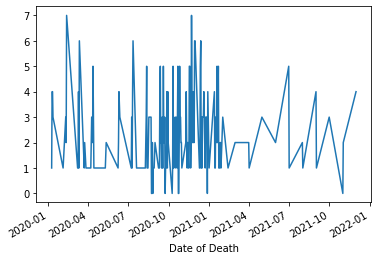

In [39]:
df_deaths
df_deaths.Deaths.plot()

In [40]:
df_deaths.head()

,Deaths
Date of Death,
2021-02-13,1
2021-11-02,2
2021-09-02,1
2021-08-02,1
2021-07-02,1


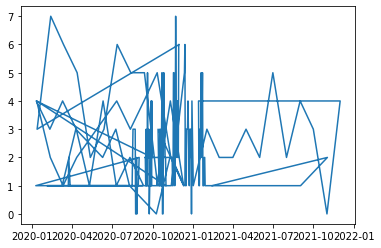

In [41]:
plt.plot(df_deaths.index, df_deaths.Deaths)

<AxesSubplot:xlabel='Date of Death'>

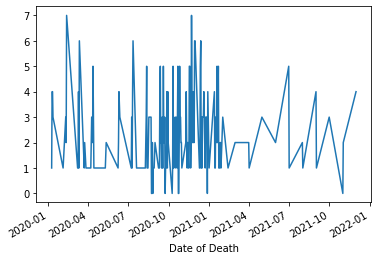

In [42]:
df_deaths
df_deaths.Deaths.plot()

In [43]:
df_deaths.Deaths.sum()

413

<AxesSubplot:xlabel='Date of Death'>

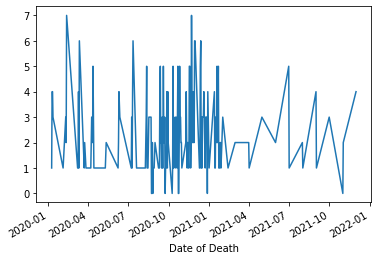

In [44]:
df_deaths.Deaths.plot()

### Third dataframe

In [45]:
df_tests = pd.read_csv('./data/Metrics by Test Date by County.csv', encoding = "utf-16le", sep='\t', header=1)
df_tests = df_tests[['Unnamed: 0', 'GREENE', 'GREENE.1', 'GREENE.2', 'GREENE.3']]
df_tests.head()
df_tests.columns = df_tests.iloc[0]
df_tests.drop(index=[0, 1], inplace=True)
df_tests.set_index('Test Date', inplace=True)
df_tests.replace({np.NaN: 0}, inplace=True)
df_tests.index = pd.to_datetime(df_tests.index)
#df_tests = df_tests.astype(int)
df_tests

,Confirmed Cases,PCR Tests,* Antigen Tests,Serology Tests
Test Date,,,,
2021-02-17,1,11,7,0
2021-02-16,20,200,114,2
2021-02-15,13,334,254,1
2021-02-14,15,234,207,0
2021-02-13,13,327,89,0
...,...,...,...,...
2020-05-03,0,0,0,0
2020-04-03,0,0,0,0
2020-03-03,0,1,0,0


In [46]:
df_tests['Confirmed Cases']

Test Date
2021-02-17     1
2021-02-16    20
2021-02-15    13
2021-02-14    15
2021-02-13    13
              ..
2020-05-03     0
2020-04-03     0
2020-03-03     0
2020-02-03     0
2020-01-03     0
Name: Confirmed Cases, Length: 354, dtype: object

In [47]:
merged_df = pd.merge(df_deaths, df_tests, left_index=True, right_index=True)
merged_df.drop(columns=['PCR Tests', '* Antigen Tests', 'Serology Tests'], inplace=True)
merged_df.head()

,Deaths,Confirmed Cases
2021-02-13,1,13
2021-11-02,2,37
2021-09-02,1,53
2021-08-02,1,75
2021-07-02,1,21


In [48]:
merged_df['Confirmed Cases'] = merged_df['Confirmed Cases'].astype(int)

In [49]:
merged_df['Cumulative Deaths'] = np.cumsum(merged_df['Deaths'])
merged_df['Cumulative Cases'] = np.cumsum(merged_df['Confirmed Cases'])
merged_df.head()

,Deaths,Confirmed Cases,Cumulative Deaths,Cumulative Cases
2021-02-13,1,13,1,13
2021-11-02,2,37,3,50
2021-09-02,1,53,4,103
2021-08-02,1,75,5,178
2021-07-02,1,21,6,199


<AxesSubplot:>

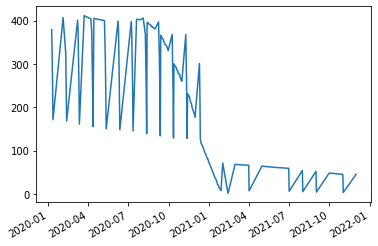

In [50]:
a = np.cumsum(merged_df['Deaths'])
a.plot()

<AxesSubplot:>

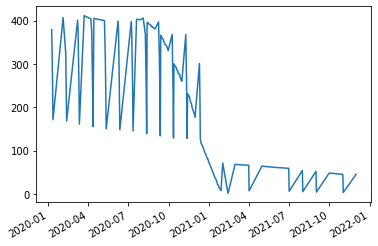

In [51]:
np.cumsum(merged_df.Deaths).plot()

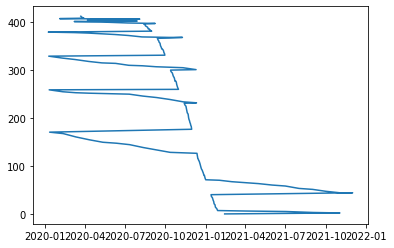

In [52]:
import matplotlib.pyplot as plt
plt.plot(merged_df.index,np.cumsum(merged_df['Deaths']))

<AxesSubplot:>

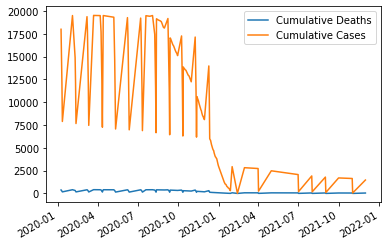

In [53]:
merged_df[['Cumulative Deaths', 'Cumulative Cases']].plot()

### NYTimes Dataset

In [54]:
os.listdir('./data')

['.~lock.Metrics by Date of Death by County.csv#',
 'Metrics by Date of Death by County.csv',
 'MetricsbyCounty.csv',
 'Metrics by Test Date by County.csv',
 'MetricsbyReportDate.csv',
 'us-counties.csv']

In [55]:
us_counties = pd.read_csv("./data/us-counties.csv")

us_counties.head()

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0.0
1,2020-01-22,Snohomish,Washington,53061.0,1,0.0
2,2020-01-23,Snohomish,Washington,53061.0,1,0.0
3,2020-01-24,Cook,Illinois,17031.0,1,0.0
4,2020-01-24,Snohomish,Washington,53061.0,1,0.0


In [56]:
us_counties = us_counties.loc[(us_counties.county == 'Greene') & (us_counties.state == 'Missouri')]
us_counties.index = pd.to_datetime(us_counties['date'])
assert sum(us_counties.fips == 29077.0) == us_counties.shape[0]
us_counties.drop(columns=['county', 'state', 'date', 'fips'], inplace=True)
us_counties.head()

,cases,deaths
date,,
2020-03-12,1,0.0
2020-03-13,1,0.0
2020-03-14,2,0.0
2020-03-15,2,0.0
2020-03-16,3,0.0


In [57]:
us_counties.tail()

,cases,deaths
date,,
2021-02-14,27048,403.0
2021-02-15,27048,403.0
2021-02-16,27157,403.0
2021-02-17,27202,404.0
2021-02-18,27226,414.0


<AxesSubplot:xlabel='date'>

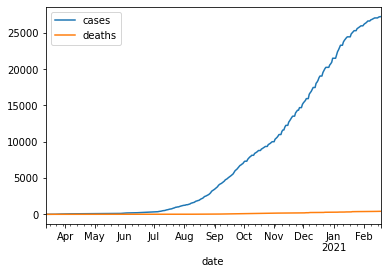

In [58]:
us_counties.plot()

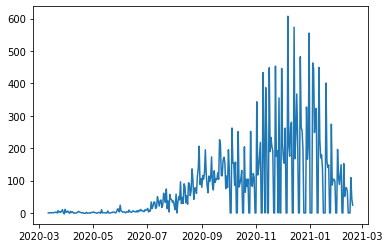

In [31]:
us_counties['daily_cases'] = np.concatenate(([0], us_counties.cases[1:].values - us_counties.cases[:-1].values))
plt.plot(us_counties.daily_cases)

In [32]:
us_counties['mean_daily_cases'] = us_counties['daily_cases'].rolling(7).mean()

<AxesSubplot:xlabel='date'>

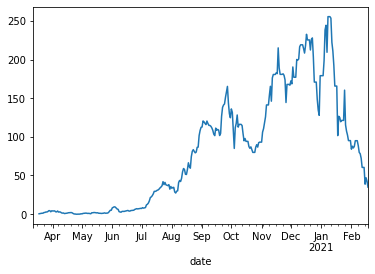

In [33]:
us_counties.mean_daily_cases.plot()

# Simulation

## Greene LockDown Parameters

In [65]:
us_counties.iloc[0]._name

Timestamp('2020-03-12 00:00:00')

Phase 0: mar 26 - may 3
   - Stay at home order (severe lockdown)
   - Private schools closed
   
Phase 1: may 4 - may 22
   - Either "max 25% occupancy" or "no more than 25 people allowed"
   - Private schools closed

Phase 2: may 23 - jun 14
   - Public gatherings from max 25 people to max 25% occupancy
   - Private schools closed

Phase 3: jun 15 - jul 15
   - Most occupancy limits went to 50%. Public gatherings remained at 25%.
   - Private schools may reopen (assumes public schools are reopened across the state in June)

Phase 3a: jul 16 - oct 11
   - Most occupancy limits went to 50%. Public gatherings remained at 25%.
   - Private schools open

Phase 3b: oct 12 - jan 9 2021
   - Most occupancy limits went to 50% (including public gatherings).
   - Private schools open


## Parameters settings

In [71]:
# Default parameters. Unless explicitly overriden, these values are used in all scenarios
common_parameters = SimulationParameters(
    mask_user_rate = 0.0,
    mask_efficacy = 0.0,
    imune_rate = 0.01,
    initial_infection_rate = 0.01,
    hospitalization_capacity = 0.05,
    latency_period_shape = 3,
    latency_period_scale = 1, 
    incubation_period_shape = 6,
    incubation_period_scale = 1, 
    mild_period_duration_shape = 14,
    mild_period_duration_scale = 1,
    hospitalization_period_duration_shape = 12,
    hospitalization_period_duration_scale = 1,
    symptomatic_isolation_rate = 0.0,
    asymptomatic_contagion_probability = 0.1,
    risk_tolerance_mean = 0.7,
    risk_tolerance_stdev = 0.2,
    herding_behavior_mean = 0.7,
    herding_behavior_stdev = 0.2,
    allowed_restaurant_capacity = 1.0, # valid values: {1.0, 0.50, 0.25}
    spreading_rate = normal_ci(2.41, 3.90, 20)
)

In [75]:
# Simulation setup
population_size = 30086

simulation_cycles = 100 # days
seed = 31415
np.random.seed(seed)
scenario = {}

In [76]:
sc = 3
params = copy.deepcopy(common_parameters)
params.params['social_policies'] = [
    SocialPolicy.LOCKDOWN_OFFICE,
    SocialPolicy.LOCKDOWN_FACTORY,
    SocialPolicy.LOCKDOWN_RETAIL,
    SocialPolicy.LOCKDOWN_ELEMENTARY_SCHOOL,
    SocialPolicy.LOCKDOWN_MIDDLE_SCHOOL,
    SocialPolicy.LOCKDOWN_HIGH_SCHOOL,
    SocialPolicy.SOCIAL_DISTANCING
]

set_parameters(params)
model = CovidModel()
np.random.seed(seed)
setup_city_layout(model, population_size)
model.add_listener(RemovePolicy(model, SocialPolicy.LOCKDOWN_ELEMENTARY_SCHOOL, 30))
model.add_listener(RemovePolicy(model, SocialPolicy.LOCKDOWN_MIDDLE_SCHOOL, 60))
model.add_listener(RemovePolicy(model, SocialPolicy.LOCKDOWN_HIGH_SCHOOL, 90))

TypeError: __init__() missing 3 required positional arguments: 'n_blobs', 'n_features', and 'home_district_in_position'

In [ ]:
model.reset_randomizer(seed)
statistics = BasicStatistics(model)
model.add_listener(statistics)
for i in range(simulation_cycles):
    model.step()
statistics.export_chart("scenario" + str(sc) + ".png")
statistics.export_csv("scenario" + str(sc) + ".csv")